# QTM 347 Project

Motivation: In this project, we’re exploring the dynamics of human compatibility and attraction in relationships. We are using speed-dating data to better understand the qualities and personalities that foster connections and mutual attraction. As young adults navigating modern relationships, we hope to gain insights that can enrich our own experiences and help us build more meaningful and fulfilling relationships. 

1. Discuss data, provide visualizations
2. Use feature selection for all variables to prove that characteristic variables are most important
3. Use feature importance to prove that decision_o and decision are similar, and we want to use decision since it has a 'like' aspect
3. Use lasso + subset selection to show important features
4. Show regression tree and interactive simulation

In [112]:
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
from scipy.stats import t as t_dist
from scipy.stats import ttest_1samp
import statsmodels.api as sm

import warnings
from sklearn.exceptions import ConvergenceWarning 
warnings.filterwarnings("ignore", category=ConvergenceWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [113]:
#import data 
data, meta = arff.loadarff('/Users/natashagandhi/Desktop/QTM 347/speeddating.arff')
#convert to DataFrame
data = pd.DataFrame(data)

#data = pd.read_csv("/Users/ishanaram/Desktop/speeddating.csv")

#fix spelling mistakes
data.rename(columns={'ambitous_o': 'ambitious_o', 'sinsere_o': 'sincere_o', 'intellicence_important': 'intelligence_important', 'ambtition_important': 'ambition_important', 'pref_o_sinsere': 'pref_o_sincere', 'd_sinsere_o': 'd_sincere_o', 'd_intellicence_important': 'd_intelligence_important', 'd_ambtition_important': 'd_ambition_important'}, inplace=True)

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(59), object(64)
memory usage: 7.9+ MB


## Variable Descriptions

| Variable                   | Description                                                   |
|----------------------------|---------------------------------------------------------------|
| gender                     | Gender of self                                                |
| age                        | Age of self                                                   |
| age_o                      | Age of partner                                                |
| d_age                      | Difference in age                                             |
| race                       | Race of self                                                  |
| race_o                     | Race of partner                                               |
| samerace                   | Whether the two persons have the same race or not             |
| importance_same_race       | How important is it that partner is of same race?             |
| importance_same_religion   | How important is it that partner has the same religion?       |
| field                      | Field of study                                                |
| pref_o_attractive          | How important does partner rate attractiveness                |
| pref_o_sincere             | How important does partner rate sincerity                     |
| pref_o_intelligence        | How important does partner rate intelligence                  |
| pref_o_funny               | How important does partner rate being funny                   |
| pref_o_ambitious           | How important does partner rate ambition                      |
| pref_o_shared_interests    | How important does partner rate having shared interests       |
| attractive_o               | Rating by partner (about me) at night of event on attractiveness |
| sincere_o                  | Rating by partner (about me) at night of event on sincerity   |
| intelligence_o             | Rating by partner (about me) at night of event on intelligence|
| funny_o                    | Rating by partner (about me) at night of event on being funny |
| ambitious_o                | Rating by partner (about me) at night of event on being ambitious |
| shared_interests_o         | Rating by partner (about me) at night of event on shared interest |
| attractive_important       | What do you look for in a partner - attractiveness            |
| sincere_important          | What do you look for in a partner - sincerity                 |
| intelligence_important     | What do you look for in a partner - intelligence              |
| funny_important            | What do you look for in a partner - being funny               |
| ambition_important         | What do you look for in a partner - ambition                  |
| shared_interests_important | What do you look for in a partner - shared interests          |
| attractive                 | Rate yourself - attractiveness                               |
| sincere                    | Rate yourself - sincerity                                     |
| intelligence               | Rate yourself - intelligence                                  |
| funny                      | Rate yourself - being funny                                   |
| ambition                   | Rate yourself - ambition                                       |
| attractive_partner         | Rate your partner - attractiveness                            |
| sincere_partner            | Rate your partner - sincerity                                  |
| intelligence_partner       | Rate your partner - intelligence                               |
| funny_partner              | Rate your partner - being funny                                |
| ambition_partner           | Rate your partner - ambition                                   |
| shared_interests_partner   | Rate your partner - shared interests                           |
| sports                     | Your own interests [1-10]                                      |
| tvsports                   | Your own interests [1-10]                                      |
| exercise                   | Your own interests [1-10]                                      |
| dining                     | Your own interests [1-10]                                      |
| museums                    | Your own interests [1-10]                                      |
| art                        | Your own interests [1-10]                                      |
| hiking                     | Your own interests [1-10]                                      |
| gaming                     | Your own interests [1-10]                                      |
| clubbing                   | Your own interests [1-10]                                      |
| reading                    | Your own interests [1-10]                                      |
| tv                         | Your own interests [1-10]                                      |
| theater                    | Your own interests [1-10]                                      |
| movies                     | Your own interests [1-10]                                      |
| concerts                   | Your own interests [1-10]                                      |
| music                      | Your own interests [1-10]                                      |
| shopping                   | Your own interests [1-10]                                      |
| yoga                       | Your own interests [1-10]                                      |
| interests_correlate        | Correlation between participant’s and partner’s ratings of interests |
| expected_happy_with_sd_people | How happy do you expect to be with the people you meet during the speed-dating event? |
| expected_num_interested_in_me | Out of the 20 people you will meet, how many do you expect will be interested in dating you? |
| expected_num_matches       | How many matches do you expect to get?                        |
| like                       | Did you like your partner?                                    |
| guess_prob_liked           | How likely do you think it is that your partner likes you?    |
| met                        | Have you met your partner before?                             |
| decision                   | Decision at night of event.                                   |
| decision_o                 | Decision of partner at night of event.                        |
| match                      | Match (yes/no)                                               |


Our dataset was found on OpenML and includes data sourced from Columbia Business School. Specifically, it includes data on experimental speed dating events from 2002 - 2004, where participants were paired with partner of the opposite sex and had a 4 minute 'first date' conversation. At different parts of the process, partipants were asked a series of questions related to demographics, dating habits, self-perceptions, and lifestyle  information.   

The dataset includes 123 features and 8378 observations.

## Data Cleaning

In [115]:
#data cleaning

#decode byte strings using 'utf-8' encoding
data = data.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

#clean columns with ?'s
columns_with_question_marks = data.columns[data.eq('?').any()]
print("Columns with '?' values:", columns_with_question_marks)

#replace with NA's
data.replace('?', np.nan, inplace=True)

#convert to csv
#file_path = '/Users/natashagandhi/Desktop/speeddating.csv'
#data.to_csv(file_path)

#convert gender to dummy 
data['female'] = data['gender'].replace({'male': 0, 'female': 1})

#convert important columns to numeric
data[['has_null', 'samerace', 'decision', 'decision_o', 'match']] = data[['has_null', 'samerace', 'decision', 'decision_o', 'match']].apply(pd.to_numeric)

#create a numerical subset 
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

#create a new subset DataFrame with only numerical columns
numerical_subset = data[numerical_columns]

#check & remove NA's
numerical_subset_clean = numerical_subset.dropna()

Columns with '?' values: Index(['race', 'race_o', 'field'], dtype='object')


In [116]:
#subset rating data

rating_partner = numerical_subset_clean[['like', 
                                         'importance_same_race',
                                         'd_age', 
                                         'samerace',
                                         'attractive_partner', 
                                         'sincere_partner', 
                                         'intelligence_partner', 
                                         'funny_partner', 
                                         'ambition_partner', 
                                         'shared_interests_partner', 
                                         'attractive_important', 
                                         'sincere_important', 
                                         'intelligence_important', 
                                         'funny_important', 
                                         'ambition_important', 
                                         'shared_interests_important', 
                                         'guess_prob_liked']]

In [117]:
pd.set_option('display.max_rows', None)

#data.isna().sum()
#data.dtypes

In [118]:
#view data
#pd.set_option('display.max_columns', None)
#data

## Data Analysis/Visualization

In [119]:
data['match'].value_counts()

0    6998
1    1380
Name: match, dtype: int64

About 16% of interactions resulted in a match.

####  Bar Plot: Perceptions of self vs how people are percieved by others

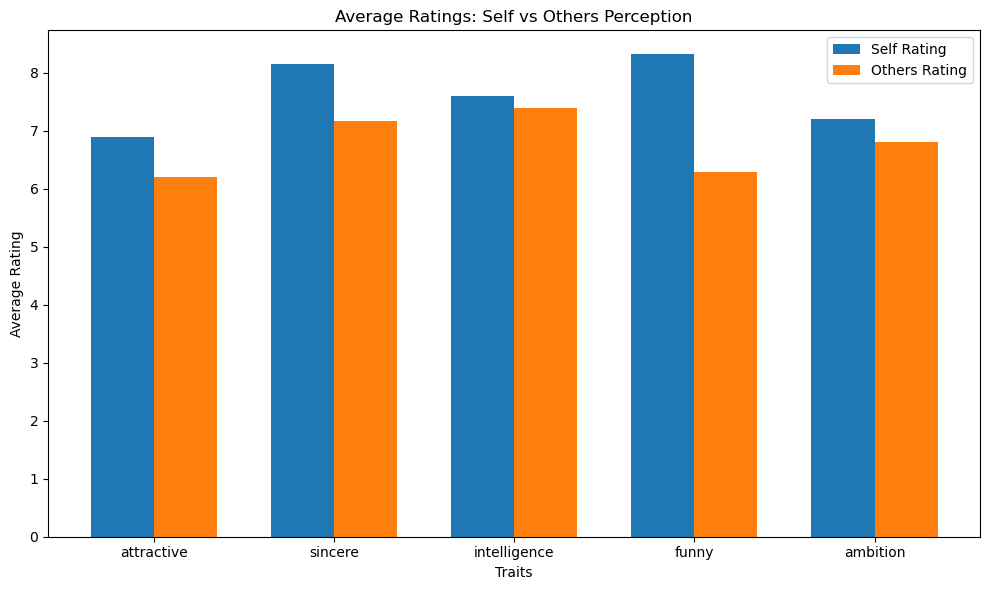

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

self_rating_vars = ['attractive', 'sincere', 'intelligence', 'funny', 'ambition']
others_rating_vars = ['attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o']
bar_width = 0.35

self_avg = numerical_subset_clean[self_rating_vars].mean()
others_avg = numerical_subset_clean[others_rating_vars].mean()

avg_data = pd.concat([self_avg, others_avg], axis=1)
avg_data.columns = ['Self Rating', 'Others Rating']

plt.figure(figsize=(10, 6))
index = range(len(self_avg))
plt.bar(index, self_avg, bar_width, label='Self Rating')
plt.bar([i + bar_width for i in index], others_avg, bar_width, label='Others Rating')
plt.title('Average Ratings: Self vs Others Perception')
plt.ylabel('Average Rating')
plt.xlabel('Traits')
plt.xticks([i + bar_width/2 for i in index], self_rating_vars)
plt.legend()
plt.tight_layout()
plt.show()

In the above plot, it's interesting to see that people tend to rate themselves higher than their partner rates them across all 5 of the characteristic variables. This highlights bias in ratings, and is something we will keep in mind during our data exploration.

#### Violin Plot: How are like (scale of 1-10) and decision (0/1) related?

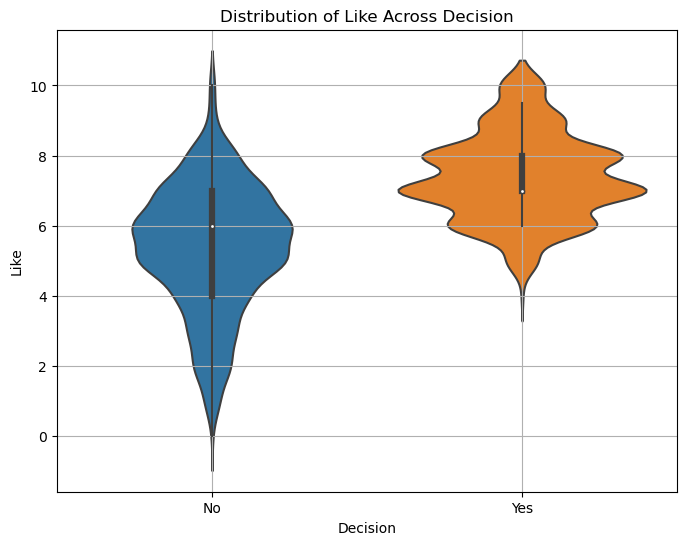

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.violinplot(x='decision', y='like', data=numerical_subset_clean)
plt.xlabel('Decision')
plt.ylabel('Like')
plt.title('Distribution of Like Across Decision')
plt.xticks([0, 1], ['No', 'Yes']) 
plt.grid()
plt.show()

In the above violin plot, we can see that some decisions are made regardless of how much they 'like' their partner. It appears that for all ratings of like, even a 10, some participants still decided that they did not want to further their connection. However it appears that a partner needed to be liked at least a 4 in order to be given a yes. So, people's ultimate decisions seems to be somewhat unpredictable, and we will therefore use 'like' as our decision variable as we feel this is a better indicator of the strength of the connection. 

#### Violin Plots: Preferences in Women vs. Men

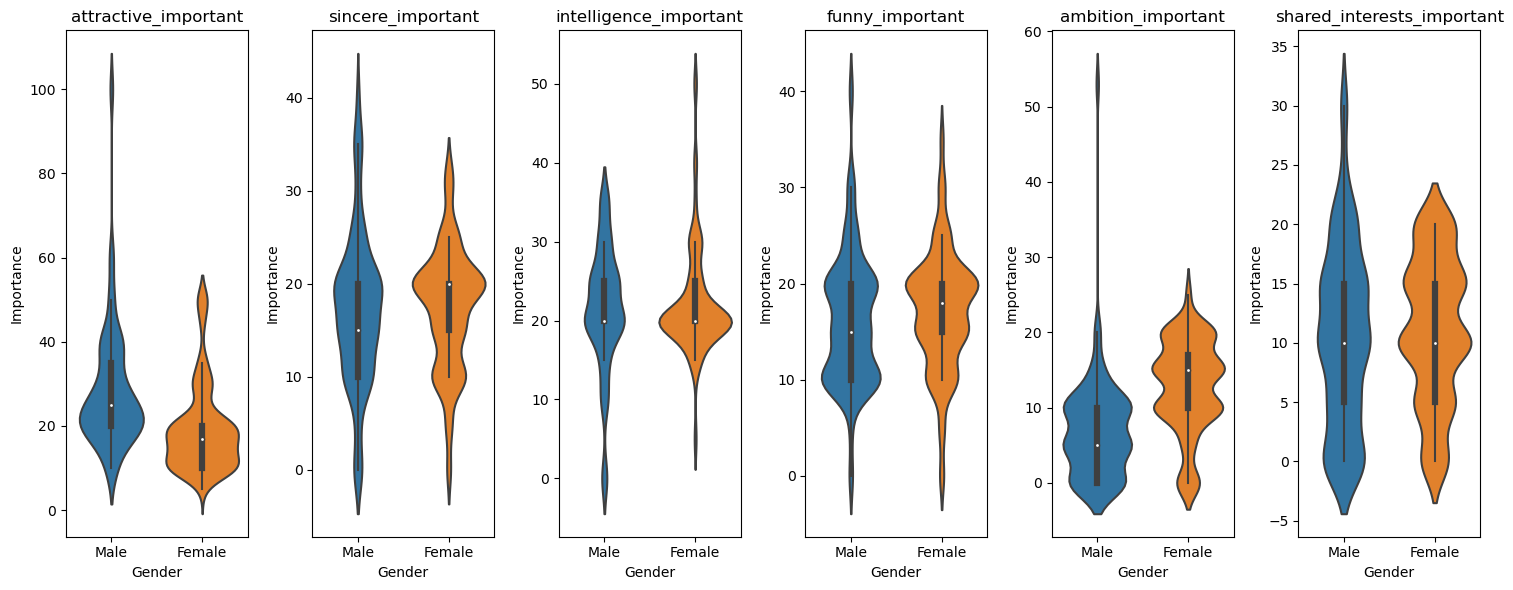

In [122]:
importance_variables = ['attractive_important', 'sincere_important', 'intelligence_important', 
                        'funny_important', 'ambition_important', 'shared_interests_important']

plt.figure(figsize=(15, 6))
for idx, var in enumerate(importance_variables):
    plt.subplot(1, len(importance_variables), idx+1)
    sns.violinplot(x='female', y=var, data=numerical_subset_clean)
    plt.title(var)
    plt.xlabel('Gender')
    plt.ylabel('Importance')
    plt.xticks([0, 1], ['Male', 'Female'])

plt.tight_layout()
plt.show()

The plot above shows variations in characteristic importance on the basis of gender. We can see that, on average, men tend to place a higher importance on partner attractiveness and women tend to place a higher importance on partner sincerity, humor and ambition.   

This male finding is consistent with previous research outlined in the paper, 'What do men and women want in a partner? Are educated partners always more desirable?' by Tobias Greitemeyer. Here, it's said that mens preference for female attraction can be explained by evolutionary theories including natural/sexual selection. Specifically, he says 'Thus, the adaptive problem for men is to identify women with high reproductive potential. Inasmuch as a female’s beauty is associated with her fertility (Buss & Barnes, 1986), men value physical attractiveness more than do women' (Greitemeyer). It's interesting to see this consistency within our data.

#### Correlation Plots

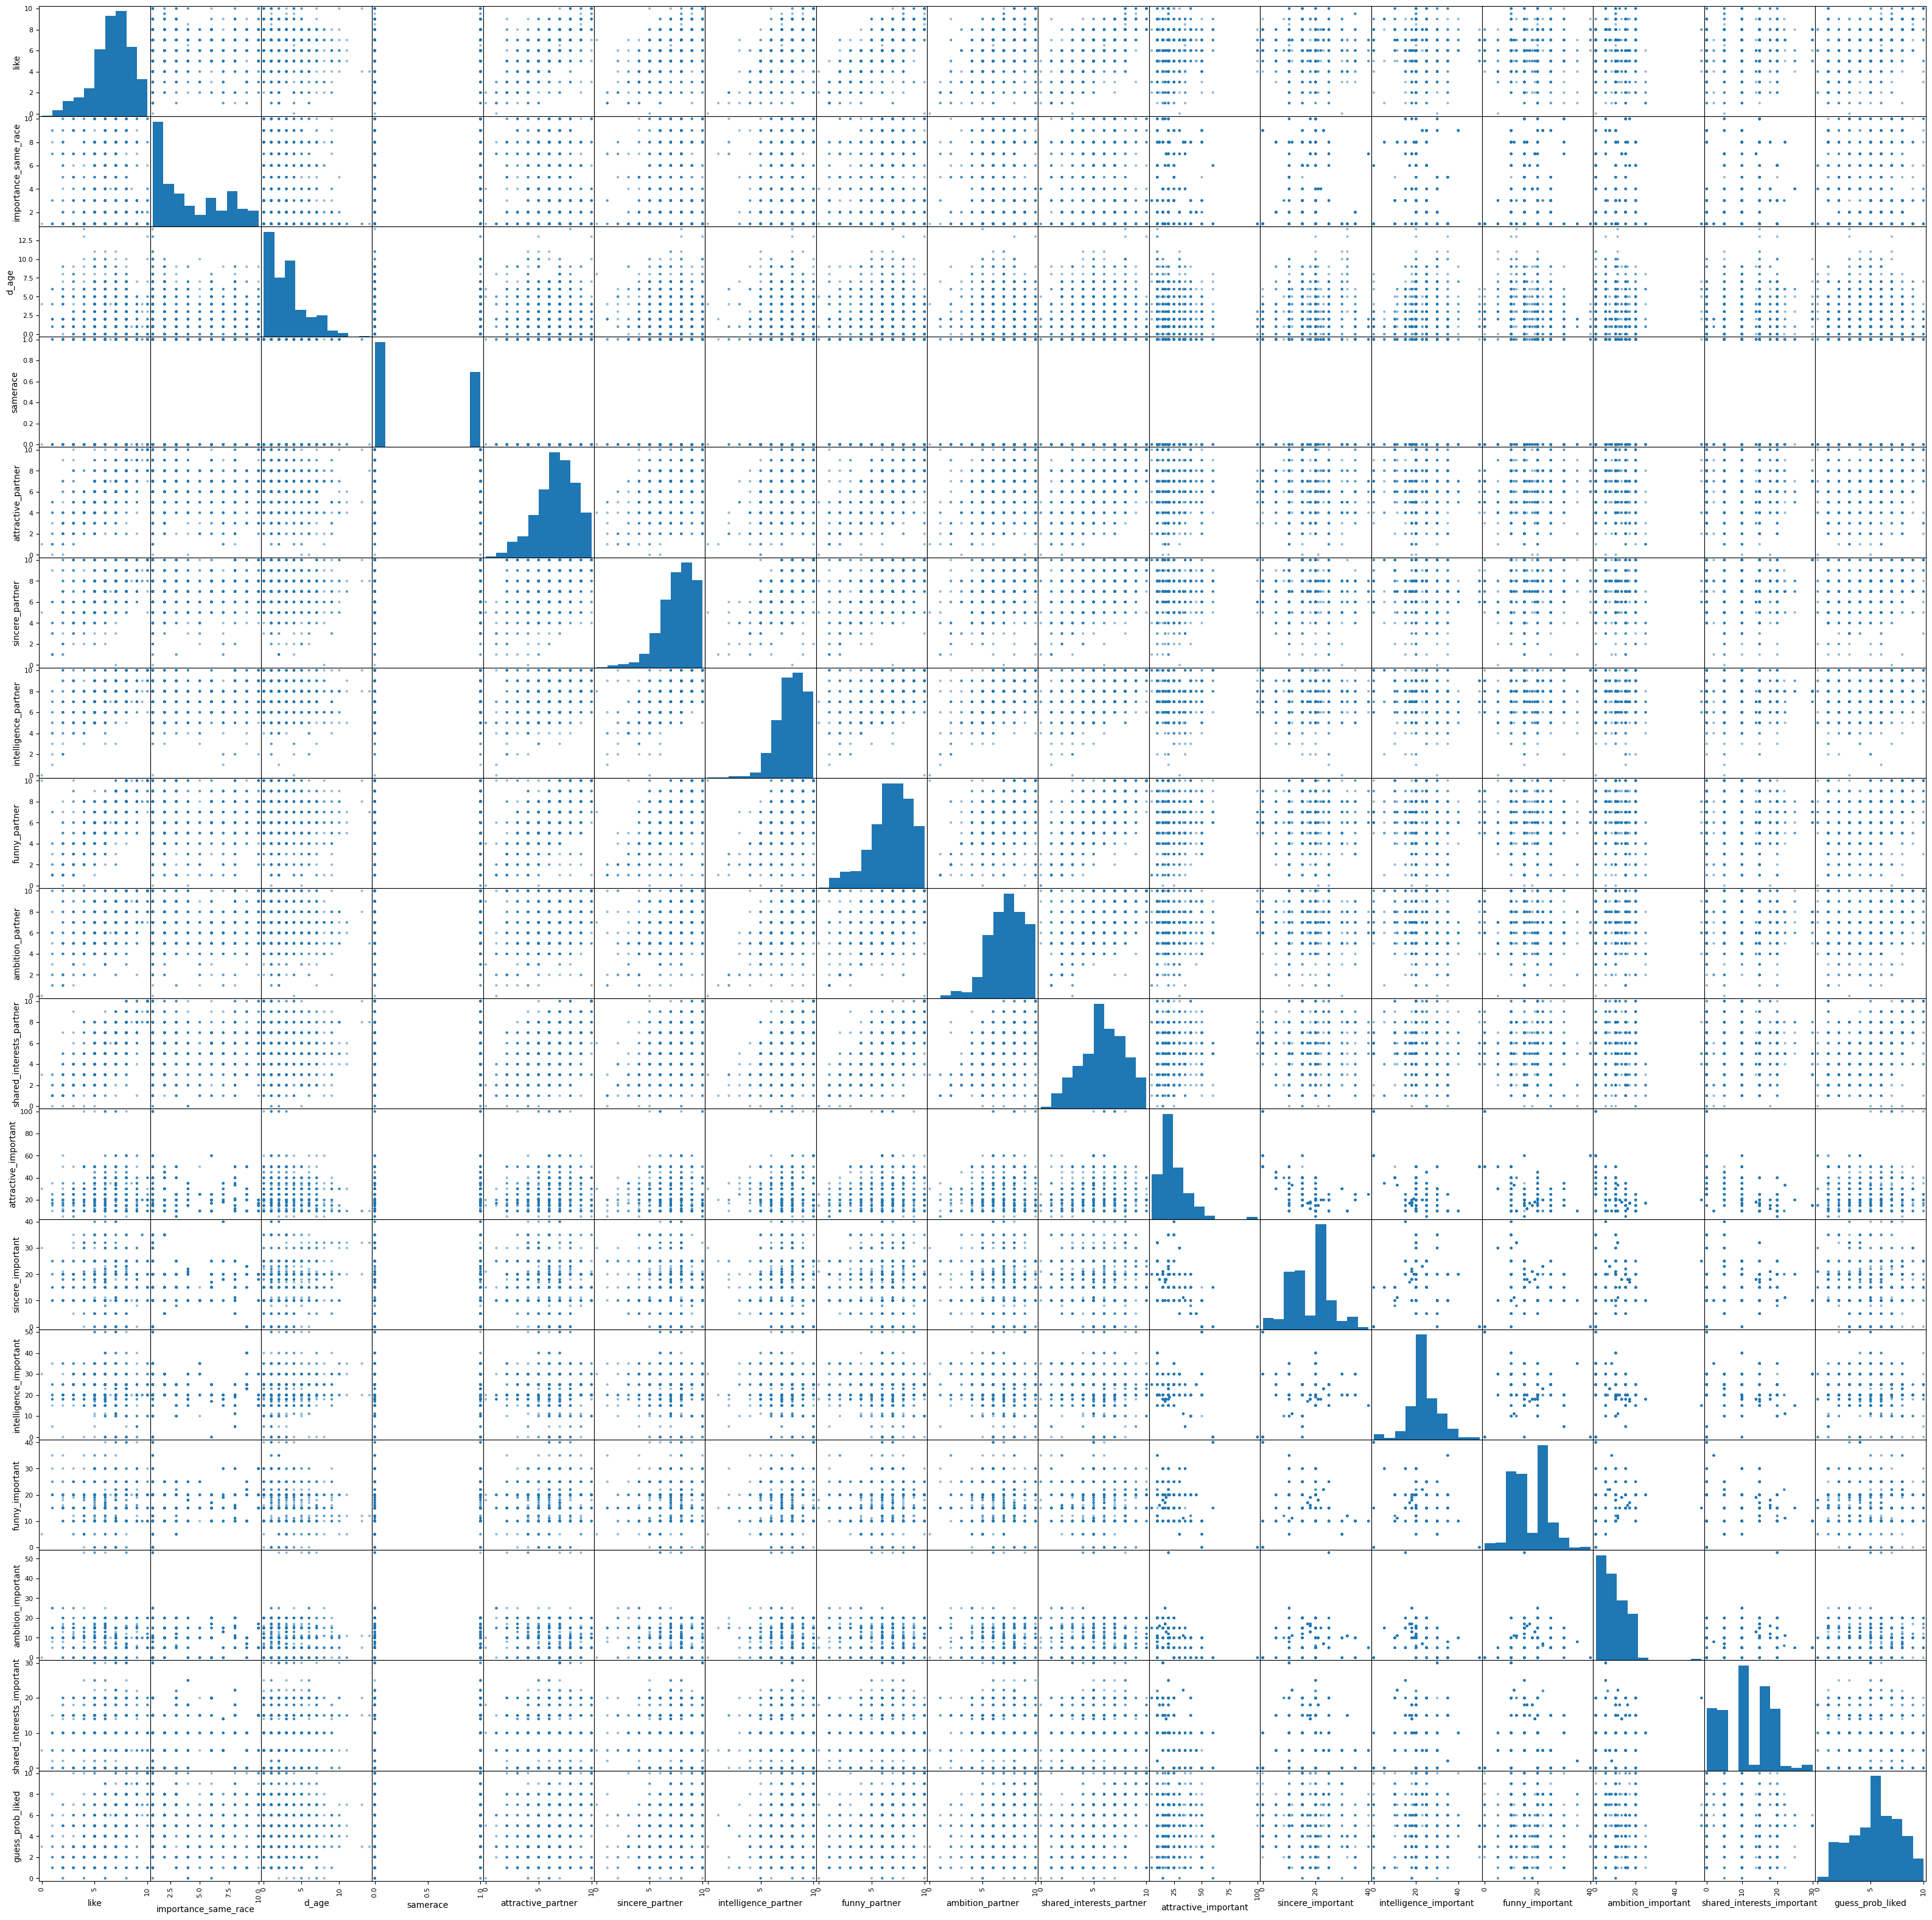

In [123]:
pd.plotting.scatter_matrix(rating_partner, figsize=(40,40))
plt.show()

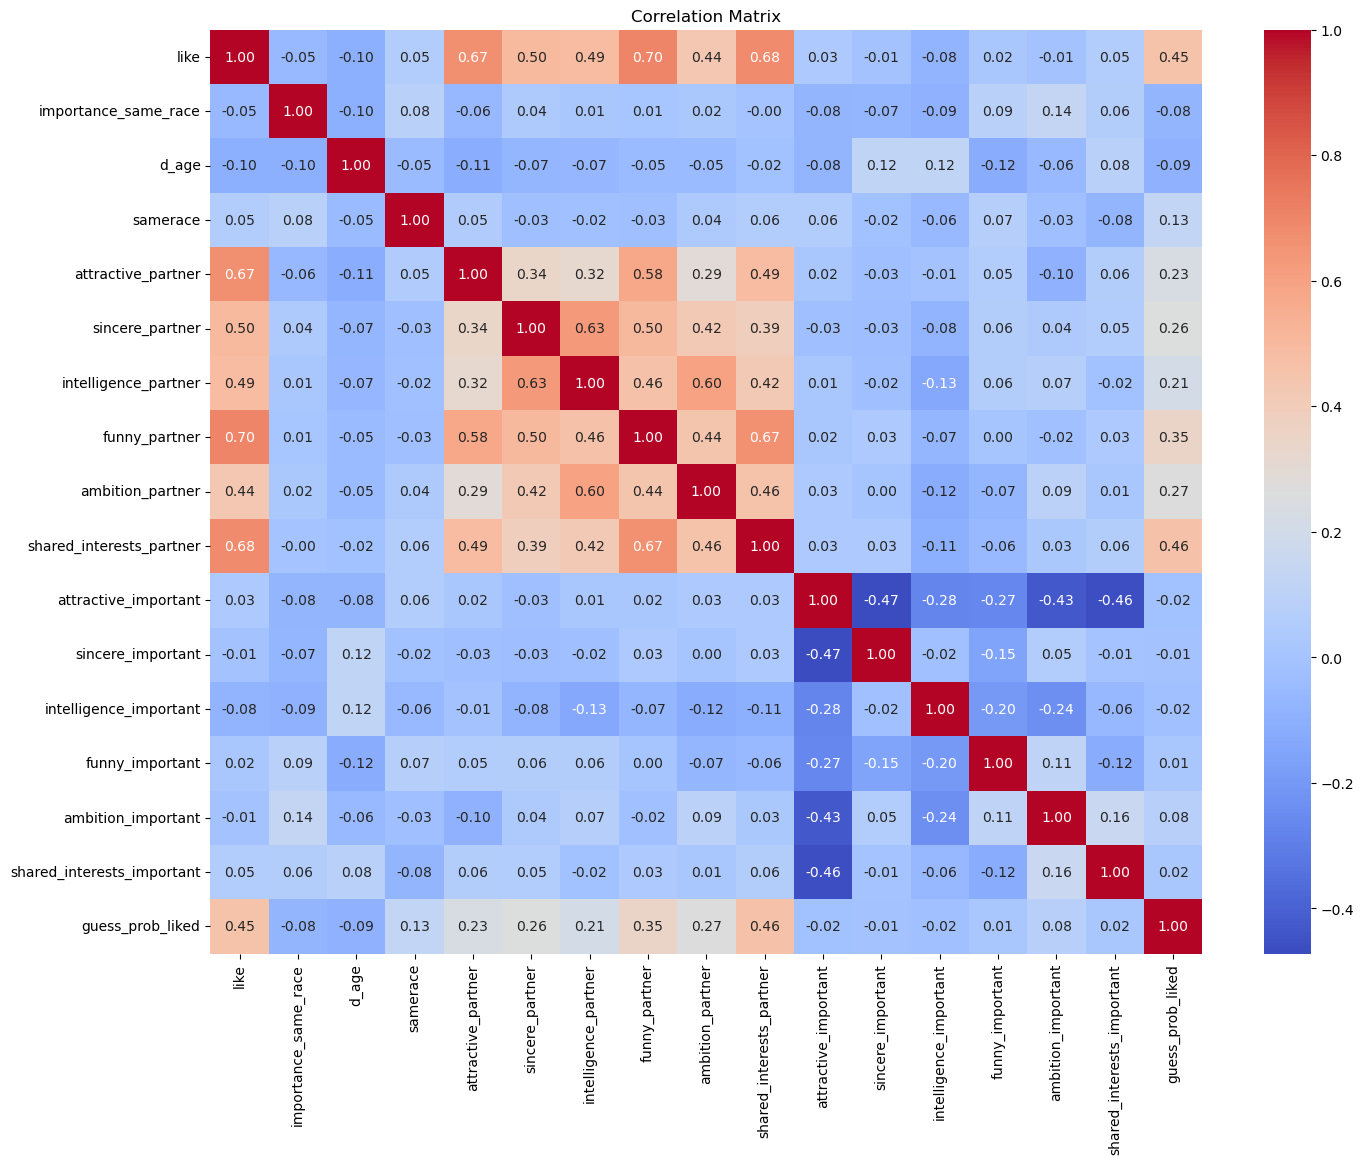

In [124]:
correlation_matrix = rating_partner.corr()
#print(correlation_matrix)

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

While very weak, we can see that the 6 partner characteristics ratings are positively correlated with like in the above graphs, with funny_partner, attractive_partner, and shared_interests_partner with the strongest correlations.

## Random Forest

In [125]:
#load packages 

from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import subplots
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor as RF

In [126]:
X_all = numerical_subset_clean.drop(columns=['match', 'decision', 'decision_o','like']) 
y_like = numerical_subset_clean['like'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_like, test_size=0.2, random_state=0)

Y = np.array(numerical_subset_clean['like'])
design = MS(numerical_subset_clean.drop(columns=['match', 'decision', 'decision_o','like'])).fit(numerical_subset_clean)
D = design.fit_transform(numerical_subset_clean)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
feature_names = list(D.columns)

In [127]:
bag_all = RF(max_features=X_train.shape[1], 
                random_state=0) 
bag_all.fit(X_train, y_train)

RandomForestRegressor(max_features=61, random_state=0)

In [128]:
train_errs = list()
test_errs = list()
num_estimators = range(1, X_train.shape[1])

feature_importances = pd.DataFrame(index=X_train.columns)

for m in num_estimators:
    rf = RF(max_features=m, random_state=0).fit(X_train, y_train)
    y_hat_RF = rf.predict(X_test)
    y_train_pred = rf.predict(X_train)
    err = np.mean((y_test - y_hat_RF)**2)
    train_err = np.mean((y_train - y_train_pred)**2)
    print(f"m = {m}, Train MSE: {train_err}, Test MSE: {err}")
    train_errs.append(train_err)
    test_errs.append(err)
    feature_importances[m] = rf.feature_importances_
    
best_m_index = np.argmin(test_errs)
best_m = num_estimators[best_m_index]
    
top_features = {}
for m in num_estimators:
    top_feats = feature_importances[m].sort_values(ascending=False).head(3).index.tolist()
    top_features[m] = top_feats
    print(f"Top 3 features for m={m}: {top_feats}")

m = 1, Train MSE: 0.23693854415274468, Test MSE: 1.592860476190475
m = 2, Train MSE: 0.20144531622911666, Test MSE: 1.3659110714285718
m = 3, Train MSE: 0.18101333532219577, Test MSE: 1.2486795238095239
m = 4, Train MSE: 0.1690497016706446, Test MSE: 1.154479642857143
m = 5, Train MSE: 0.1544883949880669, Test MSE: 1.101696547619048
m = 6, Train MSE: 0.15421795942720765, Test MSE: 1.0961647619047623
m = 7, Train MSE: 0.14866530429594255, Test MSE: 1.051677142857143
m = 8, Train MSE: 0.14352004773269714, Test MSE: 1.0235205952380955
m = 9, Train MSE: 0.14115975536992836, Test MSE: 1.0524463095238095
m = 10, Train MSE: 0.14025292362768502, Test MSE: 1.0103964285714289
m = 11, Train MSE: 0.13755990453460626, Test MSE: 1.0332273809523809
m = 12, Train MSE: 0.1390110978520289, Test MSE: 1.0116148809523802
m = 13, Train MSE: 0.1365819809069213, Test MSE: 1.0093551190476187
m = 14, Train MSE: 0.13562628281622935, Test MSE: 1.070011071428571
m = 15, Train MSE: 0.13542556682577567, Test MSE: 1.

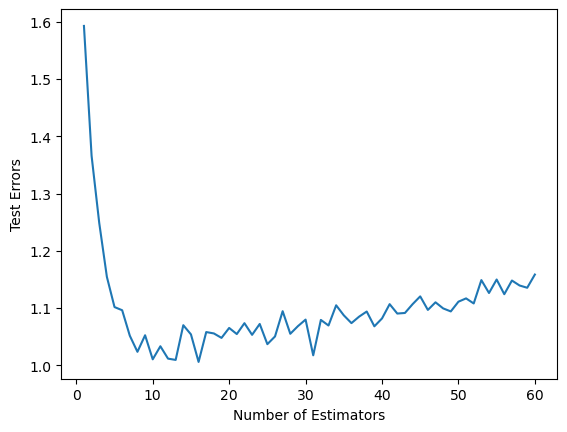

In [129]:
plt.plot(num_estimators, test_errs)

plt.xlabel('Number of Estimators')
plt.ylabel('Test Errors')
plt.show()

In [130]:
m = best_m # the best m based on test error 
rf = RF(max_features=m, random_state=0).fit(X_train, y_train)
feature_imp = pd.DataFrame({'importance':rf.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

importance
funny_partner                    0.179467
attractive_partner               0.178709
shared_interests_partner         0.155488
sincere_partner                  0.057959
guess_prob_liked                 0.051337
intelligence_partner             0.035181
ambition_partner                 0.023904
interests_correlate              0.012525
expected_num_matches             0.012295
shared_interests_o               0.009193
met                              0.008970
clubbing                         0.008428
attractive                       0.008120
pref_o_attractive                0.008111
ambition                         0.008036
age_o                            0.007992
tvsports                         0.007752
attractive_o                     0.007666
age                              0.007250
funny_o                          0.007187
expected_happy_with_sd_people    0.006910
pref_o_shared_interests          0.006869
ambitious_o                      0.006788
d_age                            0.006726
intelligence_o                   0.006698
pref_o_sincere                   0.006691
expected_num_interested_in_me    0.006642
pref_o_ambitious                 0.006621
attractive_important             0.006550
importance_same_race             0.006469
shopping                         0.006227
sincere_o                        0.006107
pref_o_intelligence              0.006077
pref_o_funny                     0.006048
hiking                           0.005727
tv                               0.005702
exercise                         0.005677
art                              0.005567
intelligence                     0.005554
gaming                           0.005482
intelligence_important           0.005284
funny_important                  0.005191
concerts                         0.004949
ambition_important               0.004945
sincere                          0.004804
importance_same_religion         0.004694
reading                          0.004669
museums                          0.004552
sports                           0.004477
sincere_important                0.004428
shared_interests_important       0.004380
yoga                             0.004091
music                            0.003676
funny                            0.003595
movies                           0.003293
theater                          0.003287
wave                             0.003082
dining                           0.003074
samerace                         0.001708
female                           0.001123
has_null                         0.000000

<Figure size 1500x1000 with 0 Axes>

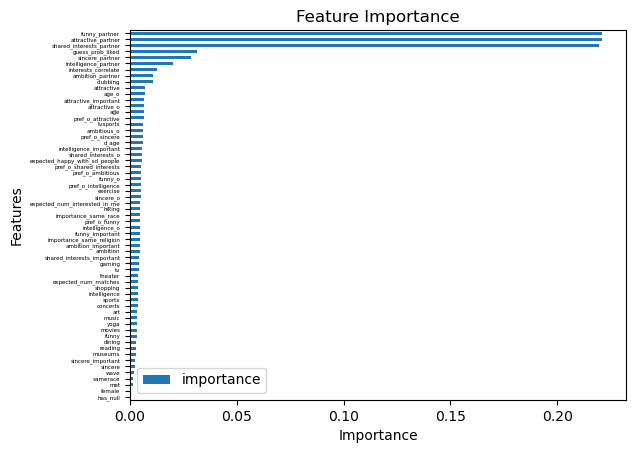

In [131]:
feature_imp = pd.DataFrame({'importance':bag_all.feature_importances_}, index=feature_names)
sorted_feature = feature_imp.sort_values(by='importance', ascending=False)

plt.figure(figsize=(15, 10)) 
sorted_feature.plot.barh()
plt.gca().invert_yaxis()  
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.yticks(fontsize=4)

plt.show()

In [132]:
## Accuracy score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

Test Mean Squared Error: 1.0058558333333334


We want to use Feature Selection, along with Random Forest and Bagging to decide which features are the most determining Decision_o - The decision of your partner on the night of the event, and Decision - Your decision the night of the event. Furthermore, we want to discover whether similar features show up in our decision vs. our partners.

First we want to look at the variable 'decision_o" which is the decision of our partner on the night of the event. We want to see which features influence your partners decision. We've included both the variables of partners scoring preference of the different features (how highly they value attractiveness, intelligence etc...) as well as the variables that show how your partner rated you on the night of the event. 

In [133]:
# Define features and target variable
features = ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
          'attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitious_o', 'shared_interests_o', 'samerace', 'd_age',  'guess_prob_liked']
target = ['decision_o']

X_o = numerical_subset_clean[features]
y_o = numerical_subset_clean[target]

# Split the data into training and testing sets
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, test_size=0.2, random_state=0)

Y_o = np.array(data[target])
design = MS(data[features]).fit(data)
D_o = design.fit_transform(data)
D_o = D_o.drop('intercept', axis=1)
X_o = np.asarray(D_o)
feature_names = list(D_o.columns)

In [134]:
bag = RF(max_features=X_train_o.shape[1], 
                random_state=0) 
bag.fit(X_train_o, y_train_o)

RandomForestRegressor(max_features=15, random_state=0)

In [135]:
train_errs = list()
test_errs = list()
num_estimators = range(1, X_train_o.shape[1])
feature_importances = pd.DataFrame(index=X_train_o.columns)

for m in num_estimators:
    rf = RF(max_features=m, random_state=0).fit(X_train_o, y_train_o)
    y_hat_RF = rf.predict(X_test_o)
    y_train_pred = rf.predict(X_train_o)
    
    test_mse = mean_squared_error(y_test_o, y_hat_RF)
    train_mse = mean_squared_error(y_train_o, y_train_pred)
    
    print(f"m = {m}, Train MSE: {train_mse}, Test MSE: {test_mse}")
    train_errs.append(train_mse)
    test_errs.append(test_mse)
    
    feature_importances[m] = rf.feature_importances_

best_m_index = np.argmin(test_errs)
best_m = num_estimators[best_m_index]

#find top features for each m
top_features = {}
for m in num_estimators:
    top_feats = feature_importances[m].sort_values(ascending=False).head(3).index.tolist()
    top_features[m] = top_feats
    print(f"Top 3 features for m={m}: {top_feats}")

m = 1, Train MSE: 0.020235680190930787, Test MSE: 0.1406885714285714
m = 2, Train MSE: 0.018833054892601432, Test MSE: 0.14356333333333332
m = 3, Train MSE: 0.018704415274463006, Test MSE: 0.14154190476190476
m = 4, Train MSE: 0.01836980906921241, Test MSE: 0.14300000000000002
m = 5, Train MSE: 0.01832112171837709, Test MSE: 0.14168952380952382
m = 6, Train MSE: 0.018783412887828164, Test MSE: 0.14134476190476192
m = 7, Train MSE: 0.01863305489260143, Test MSE: 0.13936809523809524
m = 8, Train MSE: 0.018834248210023868, Test MSE: 0.14555666666666667
m = 9, Train MSE: 0.019162410501193317, Test MSE: 0.14310380952380952
m = 10, Train MSE: 0.018651193317422435, Test MSE: 0.14376142857142857
m = 11, Train MSE: 0.01899785202863962, Test MSE: 0.14007523809523809
m = 12, Train MSE: 0.018782458233890215, Test MSE: 0.14351285714285716
m = 13, Train MSE: 0.01935930787589499, Test MSE: 0.14210952380952382
m = 14, Train MSE: 0.01909510739856802, Test MSE: 0.14572761904761902
Top 3 features for m=1

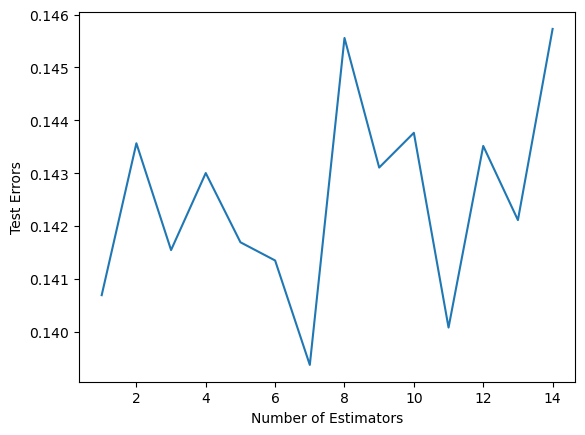

In [136]:
plt.plot(num_estimators, test_errs)

plt.xlabel('Number of Estimators')
plt.ylabel('Test Errors')

plt.show()

                         importance
attractive_o               0.310891
shared_interests_o         0.095614
pref_o_intelligence        0.073114
guess_prob_liked           0.059951
pref_o_funny               0.058474
d_age                      0.056774
funny_o                    0.053068
pref_o_sincere             0.047474
pref_o_shared_interests    0.046901
pref_o_attractive          0.046047
sincere_o                  0.042117
ambitious_o                0.038996
pref_o_ambitious           0.030872
intelligence_o             0.029806
samerace                   0.009901


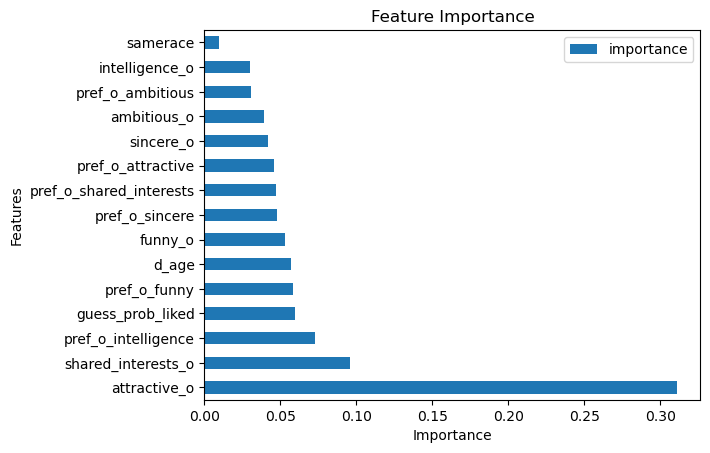

In [137]:
m = best_m
feature_imp = pd.DataFrame({'importance':bag.feature_importances_}, index=feature_names)
sorted_feature = feature_imp.sort_values(by='importance', ascending=False)
print(sorted_feature)

sorted_feature.plot.barh()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Our top 2 features are attractive_o, which is how attractive your partner rates you and shared_interests_o. This shows us that attractiveness and shared interests are the most important features in determining a partners decision during speed dating. 

Now we want to take a look at 'decision', where we are including features such as what you rated your partner on the night of the event as well as your preferences (how important is attractiveness, sincerity etc....). 

In [138]:
# Define features and target variable
features_2 = ['attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner',
          'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambition_important', 'shared_interests_important', 'samerace', 'd_age', 'guess_prob_liked']
target_2 = ['decision']

X_2 = numerical_subset_clean[features_2]
y_2 = numerical_subset_clean[target_2]

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state= 0)

Y = np.array(numerical_subset_clean[target_2])
design = MS(numerical_subset_clean[features_2]).fit(data)
D = design.fit_transform(numerical_subset_clean)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
feature_names_2 = list(D.columns)

In [139]:
# RF = random sampling + bagging 
bag_2 = RF(max_features= X_2_train.shape[1], 
                random_state=0) 
bag_2.fit(X_2_train, y_2_train)

RandomForestRegressor(max_features=15, random_state=0)

In [140]:
train_errs = list()
test_errs = list()
num_estimators = range(1, X_2_train.shape[1])
feature_importances = pd.DataFrame(index=X_2_train.columns)

for m in num_estimators:
    rf = RF(max_features=m, random_state=0).fit(X_2_train, y_2_train)
    y_hat_RF = rf.predict(X_2_test)
    y_train_pred = rf.predict(X_2_train)
    
    test_mse = mean_squared_error(y_2_test, y_hat_RF)
    train_mse = mean_squared_error(y_2_train, y_train_pred)
    
    print(f"m = {m}, Train MSE: {train_mse}, Test MSE: {test_mse}")
    train_errs.append(train_mse)
    test_errs.append(test_mse)
    
    feature_importances[m] = rf.feature_importances_

best_m_index = np.argmin(test_errs)
best_m = num_estimators[best_m_index]
    
#find top features for each m
top_features = {}
for m in num_estimators:
    top_feats = feature_importances[m].sort_values(ascending=False).head(3).index.tolist()
    top_features[m] = top_feats
    print(f"Top 3 features for m={m}: {top_feats}")

m = 1, Train MSE: 0.020798687350835322, Test MSE: 0.13249714285714287
m = 2, Train MSE: 0.019114200477326967, Test MSE: 0.12156142857142854
m = 3, Train MSE: 0.019132696897374703, Test MSE: 0.11552904761904761
m = 4, Train MSE: 0.019081861575178997, Test MSE: 0.11319619047619048
m = 5, Train MSE: 0.0189645584725537, Test MSE: 0.11648666666666667
m = 6, Train MSE: 0.018777565632458235, Test MSE: 0.11634285714285715
m = 7, Train MSE: 0.018528639618138425, Test MSE: 0.11494666666666667
m = 8, Train MSE: 0.01879295942720764, Test MSE: 0.1140247619047619
m = 9, Train MSE: 0.0186909307875895, Test MSE: 0.11304761904761904
m = 10, Train MSE: 0.019141408114558476, Test MSE: 0.1155752380952381
m = 11, Train MSE: 0.018886634844868733, Test MSE: 0.11388904761904761
m = 12, Train MSE: 0.01937183770883055, Test MSE: 0.11804857142857142
m = 13, Train MSE: 0.019062291169451073, Test MSE: 0.1142647619047619
m = 14, Train MSE: 0.019352267303102622, Test MSE: 0.11971904761904761
Top 3 features for m=1: 

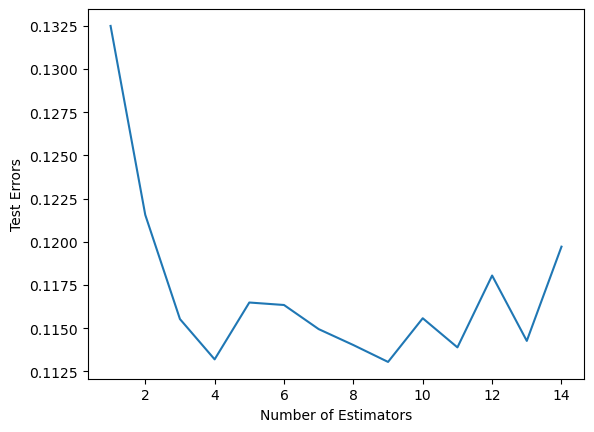

In [141]:
plt.plot(num_estimators, test_errs)

plt.xlabel('Number of Estimators')
plt.ylabel('Test Errors')

plt.show()

                            importance
attractive_partner            0.273719
shared_interests_partner      0.094232
guess_prob_liked              0.094088
funny_important               0.061398
d_age                         0.058131
intelligence_important        0.056931
funny_partner                 0.053555
sincere_partner               0.048758
sincere_important             0.047623
ambition_partner              0.045653
attractive_important          0.045533
ambition_important            0.041594
shared_interests_important    0.033865
intelligence_partner          0.030679
samerace                      0.014242


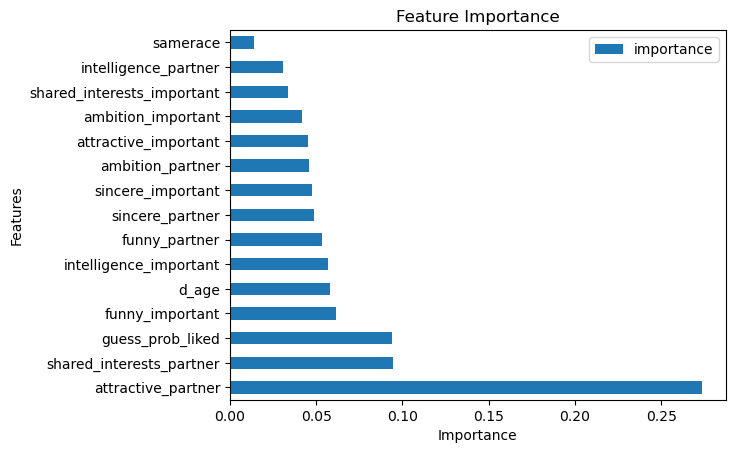

In [142]:
m = best_m
feature_imp = pd.DataFrame({'importance':bag_2.feature_importances_}, index=feature_names_2)
sorted_feature = feature_imp.sort_values(by='importance', ascending=False)
print(sorted_feature)

sorted_feature.plot.barh()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

It looks that like with 'decision', the same traits are important! Attractiveness and Shared Interests are the most important features in 'decision'. This finding is also consistent with our findings from the best subset selection. This is important since it can tell us that overall, the features that are important to us are also important to our partner!

## Subset Selection

### Best Subset Selection

We want to use best subset selection to determine the top predictors on the outcome variable 'like'. We will be using variables that contain information and ratings on the partner including 'd_age', 'samerace', 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner', and 'guess_prob_like.  We also want to include importance variables for these characteristics.

In [143]:
X = rating_partner[['importance_same_race',
                                'd_age', 
                                'samerace',
                                'attractive_partner', 
                                'sincere_partner', 
                                'intelligence_partner', 
                                'funny_partner', 
                                'ambition_partner', 
                                'shared_interests_partner', 
                                'attractive_important', 
                                'sincere_important', 
                                'intelligence_important', 
                                'funny_important', 
                                'ambition_important', 
                                'shared_interests_important', 
                                'guess_prob_liked']]

y = rating_partner['like']

#split data 80% testing, 20% training                                        
test_size = int(rating_partner.shape[0] * 0.2)
rating_partner_train, rating_partner_test = train_test_split(rating_partner, test_size=test_size, random_state=0)


#define training data
y_train = rating_partner_train['like']
X_train = rating_partner_train[['importance_same_race',
                                'd_age', 
                                'samerace',
                                'attractive_partner', 
                                'sincere_partner', 
                                'intelligence_partner', 
                                'funny_partner', 
                                'ambition_partner', 
                                'shared_interests_partner', 
                                'attractive_important', 
                                'sincere_important', 
                                'intelligence_important', 
                                'funny_important', 
                                'ambition_important', 
                                'shared_interests_important', 
                                'guess_prob_liked']]
#add a constant
X_train_cons = sm.add_constant(X_train)


#split data
#define testing data
y_test = rating_partner_test['like']
X_test = rating_partner_test[['importance_same_race',
                              'd_age', 
                              'samerace',
                             'attractive_partner', 
                            'sincere_partner', 
                            'intelligence_partner', 
                            'funny_partner', 
                            'ambition_partner', 
                            'shared_interests_partner', 
                            'attractive_important', 
                            'sincere_important', 
                            'intelligence_important', 
                            'funny_important', 
                            'ambition_important', 
                            'shared_interests_important', 
                            'guess_prob_liked']]

#add a constant
X_test_cons = sm.add_constant(X_test)


In [144]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def processSubset(feature_set, X_train_cons, y_train, X_test_cons, y_test):
    # Fit model on feature_set and calculate MSE
    if 'const' not in feature_set:
        feature_set = list(feature_set) + ['const']  # manually add intercept
    model = sm.OLS(y_train, X_train_cons[list(feature_set)]).fit()
    mse_train = mean_squared_error(y_train, model.predict(X_train_cons[list(feature_set)]))
    mse_test = mean_squared_error(y_test, model.predict(X_test_cons[list(feature_set)]))
    return {"model": model, "mse_train": mse_train, "mse_test": mse_test}

def getBest(k, X_train_cons, y_train, X_test_cons, y_test):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X_train_cons.columns.drop('const'), k):
        results.append(processSubset(combo, X_train_cons, y_train, X_test_cons, y_test))
    
    # Wrap everything up in a nice DataFrame
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest MSE for training
    best_model = models.loc[models['mse_train'].idxmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc - tic), "seconds.")
    
    return best_model

In [145]:
models_best = pd.DataFrame(columns=["mse_train", "mse_test", "model"])

for i in range(1, 4):  
    models_best.loc[i] = getBest(i, X_train_cons, y_train, X_test_cons, y_test)

print("Best model with 3 predictors Training MSE:", models_best.loc[3, "mse_train"])
print("Best model with 3 predictors Testing MSE:", models_best.loc[3, "mse_test"])
print(models_best.loc[3, "model"].summary())

Processed 16 models on 1 predictors in 0.020904064178466797 seconds.
Processed 120 models on 2 predictors in 0.15150785446166992 seconds.
Processed 560 models on 3 predictors in 0.6660850048065186 seconds.
Best model with 3 predictors Training MSE: 1.1534185844579106
Best model with 3 predictors Testing MSE: 1.368364626343596
                            OLS Regression Results                            
Dep. Variable:                   like   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     562.2
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          7.66e-200
Time:                        12:39:07   Log-Likelihood:                -1250.4
No. Observations:                 839   AIC:                             2509.
Df Residuals:                     835   BIC:                             2528.
Df Model:                           3   

In the above best subset selection output, we can see that the top three predictors of like include attractive_partner, shared_interests_partner, and funny_partner. Training MSE = 1.153418584, Test MSE = 1.3683646

## Lasso Regression/ Feature Selection

In [146]:
from sklearn.pipeline import Pipeline
import sklearn.model_selection as skm
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
from sklearn.linear_model import Lasso

In [147]:
Y = np.array(rating_partner['like'])
design = MS(rating_partner.columns.drop('like')).fit(rating_partner)
D = design.fit_transform(rating_partner)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [148]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1, 
                           cv=kfold)
scaler = StandardScaler(with_mean=True, with_std=True)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.021298468832636735

In [149]:
lasso = skl.ElasticNet(alpha= tuned_lasso.alpha_ 
                       , l1_ratio=1)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)]) 
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=0.021298468832636735, l1_ratio=1))])

In [150]:
#test MSE
test_pred = pipe.predict(X_test)
np.mean((y_test - test_pred)**2)

1.1564421955496138

In [151]:
#training MSE
train_pred = pipe.predict(X_train)
np.mean((train_pred - y_train)**2)

1.0312009921697962

In [152]:
coefficients = dict(zip(X_train.columns, lasso.coef_))
lasso_table = pd.DataFrame({'Feature': list(coefficients.keys()), 'Coefficient': list(coefficients.values())})
lasso_table_sorted = lasso_table.sort_values(by='Coefficient', ascending=False)

print(lasso_table_sorted.to_string(index=False))

                   Feature  Coefficient
        attractive_partner     0.622564
  shared_interests_partner     0.480673
             funny_partner     0.367187
          guess_prob_liked     0.240499
      intelligence_partner     0.190104
           sincere_partner     0.135778
      attractive_important     0.006206
                     d_age    -0.000000
                  samerace     0.000000
          ambition_partner     0.000000
         sincere_important     0.000000
           funny_important    -0.000000
        ambition_important    -0.000000
shared_interests_important     0.000000
    intelligence_important    -0.010303
      importance_same_race    -0.025238


In [153]:
Y = np.array(y).ravel()

In [154]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(4, -6, 101) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, 
                                 l1_ratio=1., 
                                 alphas=lambdas)[1]
soln_array.shape

(16, 101)

In [155]:
lambdas , soln_array = skl.Lasso.path(Xs, Y, 
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))

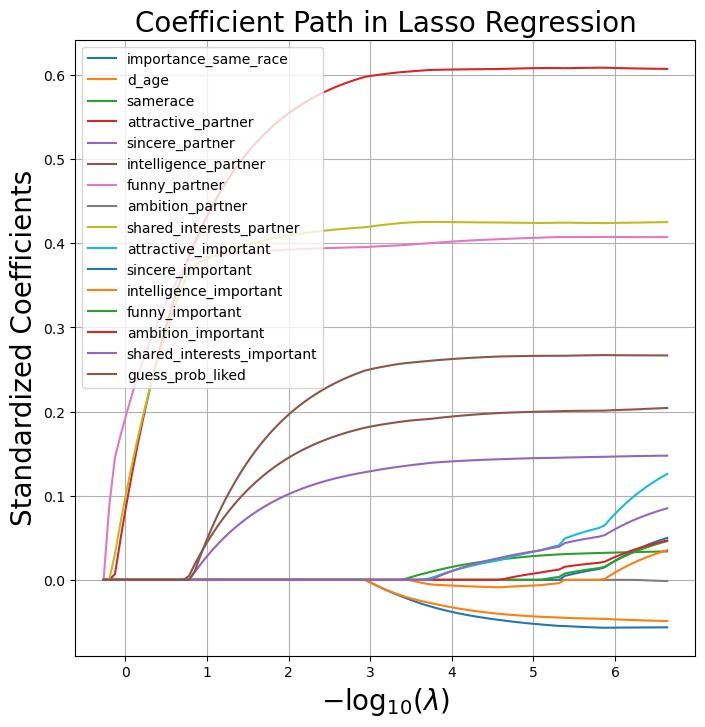

In [156]:
fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax) 
ax.set_xlabel('$-\log_{10}(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized Coefficients', fontsize=20)
ax.set_title('Coefficient Path in Lasso Regression', fontsize=20)
plt.grid(True)
plt.show()

# Regression Trees

Given our findings mentioned above, we want to create pruned regression trees with decision variables of 'decision' and 'like'. Through our previous feature selection analyses, we have determined the variables we would like to include be 'd_age', 'samerace', 'attractive_partner', 'sincere_partner', 'intelligence_partner','funny_partner', 'ambition_partner', and 'shared_interests_partner'

In [157]:
from sklearn.tree import DecisionTreeRegressor as DTR
from matplotlib.pyplot import subplots
from sklearn.tree import plot_tree
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split

### 1. With 'like' as the decision variable

In [158]:
np.random.seed(123)

reg = DTR()
reg.fit(X_train, y_train)

#test MSE
np.mean((y_test - reg.predict(X_test))**2)

2.2117224880382773

In [159]:
#training MSE
train_pred = reg.predict(X_train)
np.mean((train_pred - y_train)**2)

0.0

In [160]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
num_arangees_per_splits = np.arange(2,11,2)
num_min_samples_leaf = range(1,6)


param_grid = {'ccp_alpha': ccp_path.ccp_alphas, 
              'min_samples_split': num_arangees_per_splits, 
              'min_samples_leaf': num_min_samples_leaf
             }


kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=0) 


grid = skm.GridSearchCV(reg,
                        param_grid,
                        refit=True,
                        cv=kfold, 
                        scoring='neg_mean_squared_error')


G = grid.fit(X_train, y_train)

best_ = grid.best_estimator_
print(grid.best_params_, np.mean((y_test - best_.predict(X_test))**2))

#1.710249225443976

{'ccp_alpha': 0.008971253540441166, 'min_samples_leaf': 4, 'min_samples_split': 2} 1.710249225443976


In [161]:
#test MSE
np.mean((y_test - best_.predict(X_test))**2)

#test MSE decreased

1.710249225443976

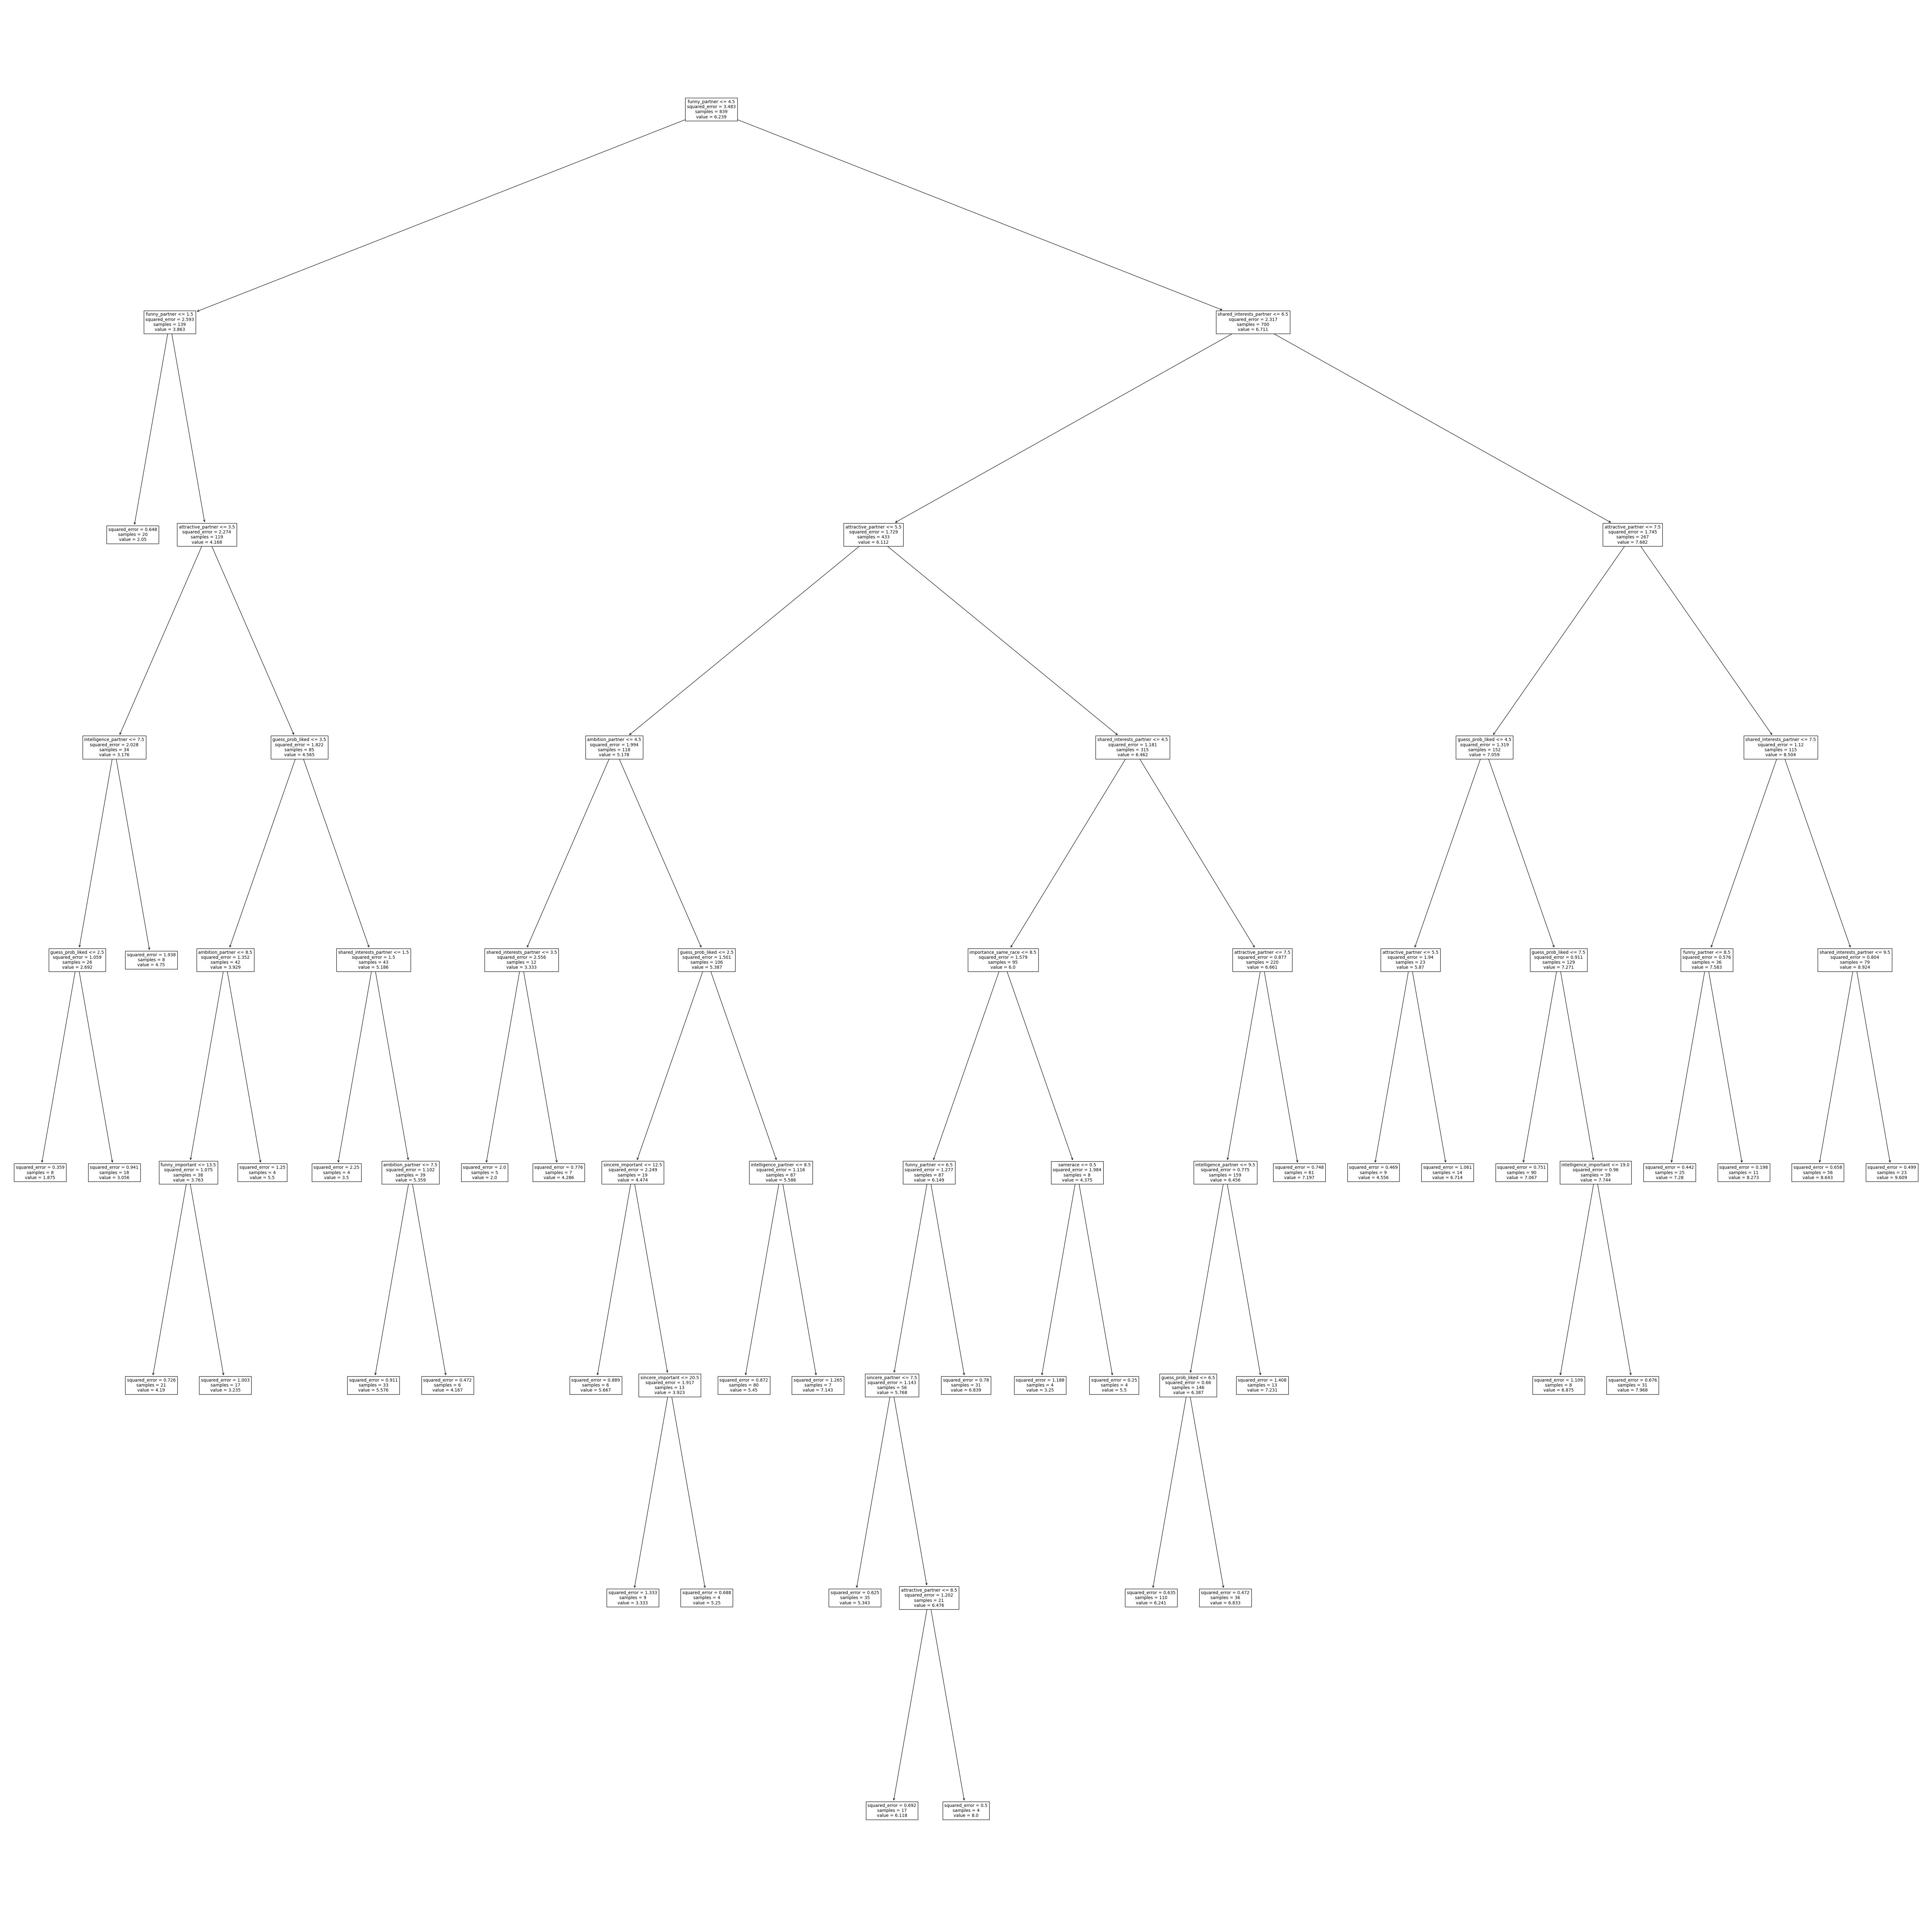

In [162]:
#plot tree
ax = subplots(figsize=(80,80))[1] 

plot_tree(best_, 
          feature_names=X_train.columns, 
          ax=ax);

In [163]:
print(export_text(best_,
                  feature_names= X_train.columns,
show_weights=True))

|--- funny_partner <= 4.50
|   |--- funny_partner <= 1.50
|   |   |--- value: [2.05]
|   |--- funny_partner >  1.50
|   |   |--- attractive_partner <= 3.50
|   |   |   |--- intelligence_partner <= 7.50
|   |   |   |   |--- guess_prob_liked <= 2.50
|   |   |   |   |   |--- value: [1.88]
|   |   |   |   |--- guess_prob_liked >  2.50
|   |   |   |   |   |--- value: [3.06]
|   |   |   |--- intelligence_partner >  7.50
|   |   |   |   |--- value: [4.75]
|   |   |--- attractive_partner >  3.50
|   |   |   |--- guess_prob_liked <= 3.50
|   |   |   |   |--- ambition_partner <= 8.50
|   |   |   |   |   |--- funny_important <= 13.50
|   |   |   |   |   |   |--- value: [4.19]
|   |   |   |   |   |--- funny_important >  13.50
|   |   |   |   |   |   |--- value: [3.24]
|   |   |   |   |--- ambition_partner >  8.50
|   |   |   |   |   |--- value: [5.50]
|   |   |   |--- guess_prob_liked >  3.50
|   |   |   |   |--- shared_interests_partner <= 1.50
|   |   |   |   |   |--- value: [3.50]
|   |   |   |

According to the pruned tree, the features that are considered important are funny_partner, attractive_partner, and shared_interest_partner. These features are included in the top splits of the tree and are therefore considered more important. Some of the other variables that were selected include intelligence_partner, guess_prob_liked, ambition_partner, funny_important, importance_same_race, sincere_partner, sincere_important,  samerace, and intelligence_important.

In [ ]:
def calculate_like(importance_same_race, d_age, samerace, attractive_partner, sincere_partner, intelligence_partner,
                   funny_partner, ambition_partner, shared_interests_partner, allocated_points, guess_prob_liked, funny_important, sincere_important, intelligence_important):
    if funny_partner <= 4.50:
        if funny_partner <= 1.50:
            return 2.05
        else:
            if attractive_partner <= 3.50:
                if intelligence_partner <= 7.50:
                    if guess_prob_liked <= 2.50:
                        return 1.88
                    else:
                        return 3.06
                else:
                    return 4.75
            else:
                if guess_prob_liked <= 3.50:
                    if ambition_partner <= 8.50:
                        if funny_important <= 13.50:
                            return 4.19
                        else:
                            return 3.24
                    else:
                        return 5.50
                else:
                    if ambition_partner <= 8.50:
                        if funny_important <= 12.50:
                            return 6.20
                        else:
                            if sincere_partner <= 4.50:
                                return 3.60
                            else:
                                return 5.38
                    else:
                        return 3.50
    else:
        if shared_interests_partner <= 6.50:
            if attractive_partner <= 5.50:
                if ambition_partner <= 4.50:
                    if shared_interests_partner <= 3.50:
                        return 2.00
                    else:
                        if guess_prob_liked <= 2.50:
                            if sincere_important <= 12.50:
                                return 5.67
                            else:
                                if sincere_important <= 20.50:
                                    return 3.33
                                else:
                                    return 5.25
                        else:
                            if intelligence_partner <= 8.50:
                                return 5.45
                            else:
                                return 7.14
                else:
                    if guess_prob_liked <= 2.50:
                        return 5.67
                    else:
                        if intelligence_partner <= 8.50:
                            return 5.45
                        else:
                            return 7.14
            else:
                if shared_interests_partner <= 4.50:
                    if importance_same_race <= 8.50:
                        if funny_partner <= 6.50:
                            if sincere_partner <= 7.50:
                                return 5.34
                            else:
                                if attractive_partner <= 8.50:
                                    return 6.12
                                else:
                                    return 8.00
                        else:
                            return 6.84
                    else:
                        if samerace <= 0.50:
                            return 3.25
                        else:
                            return 5.50
                else:
                    if attractive_partner <= 7.50:
                        if intelligence_partner <= 9.50:
                            if guess_prob_liked <= 6.50:
                                return 6.24
                            else:
                                return 6.83
                        else:
                            return 7.23
                    else:
                        return 7.20
        else:
            if attractive_partner <= 7.50:
                if guess_prob_liked <= 4.50:
                    if attractive_partner <= 5.50:
                        return 4.56
                    else:
                        return 6.71
                else:
                    if guess_prob_liked <= 7.50:
                        return 7.07
                    else:
                        if intelligence_important <= 19.00:
                            return 6.88
                        else:
                            return 7.97
            else:
                if shared_interests_partner <= 7.50:
                    if funny_partner <= 8.50:
                        return 7.28
                    else:
                        return 8.27
                else:
                    if shared_interests_partner <= 9.50:
                        return 8.64
                    else:
                        return 9.61
def take_user_inputs():
    importance_same_race = int(input("How important is it to you that your partner is of the same race? (1-10): "))
    d_age = float(input("What is the age difference between you and your partner?: "))
    
    while True:
        samerace_input = input("Are you and your partner of the same race? (yes/no): ").lower()
        if samerace_input in ['yes', 'no']:
            break
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")

    samerace = 1 if samerace_input == 'yes' else 0
    
    attractive_partner = int(input("On a scale of 1-10, how attractive do you find your partner?: "))
    sincere_partner = int(input("On a scale of 1-10, how sincere do you find your partner?: "))
    intelligence_partner = int(input("On a scale of 1-10, how intelligent do you find your partner?: "))
    funny_partner = int(input("On a scale of 1-10, how funny do you find your partner?: "))
    ambition_partner = int(input("On a scale of 1-10, how ambitious do you find your partner?: "))
    shared_interests_partner = int(input("On a scale of 1-10, how many shared interests do you have with your partner?: "))
    guess_prob_liked = int(input("\nOn a scale of 1-10, how much do you think your partner likes you?: "))

    print("\nYou have 100 points to allocate for the following 6 characteristics:")
    print("1. Attractiveness")
    print("2. Sincerity")
    print("3. Intelligence")
    print("4. Funniness")
    print("5. Ambition")
    print("6. Shared Interests")

    allocated_points = {}
    characteristics = ['Attractiveness', 'Sincerity', 'Intelligence', 'Funniness', 'Ambition', 'Shared Interests']
    remaining_points = 100

    for characteristic in characteristics:
        while True:
            try:
                print(f"\nYou have {remaining_points} points remaining.")
                points = int(input(f"Allocate points for {characteristic}: "))
                if points < 0 or points > remaining_points:
                    raise ValueError(f"Please enter a valid integer within the range (0-{remaining_points}).")
                allocated_points[characteristic] = points
                remaining_points -= points
                break
            except ValueError as e:
                print("Invalid input:", e)

    # Check if the total allocated points equal 100
    if remaining_points != 0:
        print("You have not allocated all 100 points. Please allocate all points.")
        exit()

    # Define specific variables for each characteristic
    attractive_important = allocated_points['Attractiveness']
    sincere_important = allocated_points['Sincerity']
    intelligence_important = allocated_points['Intelligence']
    funny_important = allocated_points['Funniness']
    ambition_important = allocated_points['Ambition']
    shared_interests_important = allocated_points['Shared Interests']


    return (importance_same_race, d_age, samerace, attractive_partner, sincere_partner, intelligence_partner,
            funny_partner, ambition_partner, shared_interests_partner, allocated_points, guess_prob_liked, funny_important, sincere_important, intelligence_important)

def main():
    print("Welcome to the partner liking calculator!")
    print("Please answer the following questions:")
    inputs = take_user_inputs()
    like_value = calculate_like(*inputs)
    print("Based on your inputs, your liking score for your partner is:", like_value)

if __name__ == "__main__":
    main()

Welcome to the partner liking calculator!
Please answer the following questions:


## Literature Review

Greitemeyer, Tobias. “What Do Men and Women Want in a Partner? Are Educated Partners Always More Desirable?” Journal of Experimental Social Psychology, Academic Press, 29 Mar. 2006, www.sciencedirect.com/science/article/abs/pii/S0022103106000345. 